# Bitcoin Sentiment Analysis
This notebook performs real-time Bitcoin sentiment analysis using news data and price information.

## Setup and Dependencies

In [28]:
# # Import required libraries
# import pandas as pd
# import numpy as np
# from datetime import datetime, timedelta
# import os
# from dotenv import load_dotenv
# from textblob import TextBlob
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# import requests
# from newsapi import NewsApiClient
# from pycoingecko import CoinGeckoAPI

## Initialize API Clients

In [29]:
from src.common import NEWS_API_KEY, RELEVANT_SOURCES, newsapi, coingecko

In [30]:
from src.fetch_data import fetch_bitcoin_news, fetch_bitcoin_prices
from src.data_saver import save_data, load_data, format_sentiment_score#, get_sentiment_color 



from src.utils_analyzer import analyze_sentiment, aggregate_sentiment, prepare_time_series_data, run_forecast, compare_historical_sentiment

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

use_cached_data = True  # Set to False to fetch fresh data

# Date range
end_date = datetime.now().date()
start_date = end_date - timedelta(days=29)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

In [32]:
# === 1. Fetch and Process News Articles ===
if use_cached_data:
    print("Loading cached news articles and sentiment data...")
    articles = load_data("articles_data.csv")
    aggregated_sentiment = load_data("aggregated_sentiment.csv")
else:
    print("Fetching Bitcoin-related news...")
    new_articles_fetch = fetch_bitcoin_news(start_date_str, end_date_str, refresh=True)
    new_articles = analyze_sentiment(new_articles_fetch)

    # Load old data and merge
    old_articles = load_data("articles_data.csv")
    if old_articles is not None:
        articles = pd.concat([old_articles, new_articles], ignore_index=True)
        # articles = articles.drop_duplicates(subset=['url'])
        
    else:
        articles = new_articles

    # Aggregate sentiment
    aggregated_sentiment = aggregate_sentiment(articles)

    # Save updated versions
    save_data(articles, "articles_data.csv")
    save_data(aggregated_sentiment, "aggregated_sentiment.csv")


Loading cached news articles and sentiment data...
2025-05-10 22:24:07 - src.common - INFO - Loaded data from data/articles_data.csv
2025-05-10 22:24:07 - src.common - INFO - Loaded data from data/aggregated_sentiment.csv


In [33]:

# === 2. Fetch and Process Bitcoin Prices ===
if use_cached_data:
    print("Loading cached Bitcoin price data...")
    price_data = load_data("price_data.csv")
else:
    print("Fetching Bitcoin price data...")
    new_prices = fetch_bitcoin_prices(start_date_str, end_date_str, refresh=True)

    # Load old data and merge
    old_prices = load_data("price_data.csv")
    if old_prices is not None:
        price_data = pd.concat([old_prices, new_prices], ignore_index=True)
        price_data = price_data.drop_duplicates(subset=['date'])
    else:
        price_data = new_prices

    save_data(price_data, "price_data.csv")

Loading cached Bitcoin price data...
2025-05-10 22:24:07 - src.common - INFO - Loaded data from data/price_data.csv


In [34]:
# === 3. Prepare Time Series ===
print("Merging sentiment and price data...")
merged_data = prepare_time_series_data(aggregated_sentiment, price_data)
# merged_data['price_diff'] = merged_data['close_price'].diff().dropna()
merged_data = merged_data.drop_duplicates()
# merged_data

Merging sentiment and price data...
2025-05-10 22:24:07 - src.utils_analyzer - INFO - Preparing time series data...
2025-05-10 22:24:07 - src.utils_analyzer - INFO - Sentiment date range: 2025-04-12 00:00:00 to 2025-05-10 00:00:00
2025-05-10 22:24:07 - src.utils_analyzer - INFO - Price date range: 2025-04-11 00:00:00 to 2025-05-11 00:00:00
2025-05-10 22:24:07 - src.utils_analyzer - INFO - Time series data prepared with 28 days.


In [35]:






# === 4. Run Forecast ===
print("Running forecast...")
forecast_results, future_forecast = run_forecast(merged_data)

# === 5. Visualization with Matplotlib / Seaborn ===
def plot_sentiment_trends(sentiment_df):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(data=sentiment_df, x='date', y='avg_polarity', ax=ax)
    ax.set_title("Average Sentiment Polarity Over Time")
    ax.set_ylabel("Polarity")
    ax.set_xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_price_trends(price_df):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(data=price_df, x='date', y='close_price', ax=ax)
    ax.set_title("Bitcoin Close Price Over Time")
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_price_vs_sentiment(merged_df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=merged_df, x='avg_polarity', y='price', ax=ax)
    sns.regplot(data=merged_df, x='avg_polarity', y='price', scatter=False, ax=ax, color='red')
    ax.set_title("Bitcoin Price vs Sentiment Polarity")
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Sentiment Polarity")
    plt.tight_layout()
    plt.show()

def plot_forecast(forecast_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(forecast_df['date'], forecast_df['actual_price'], label='Actual', color='blue')
    ax.plot(forecast_df['date'], forecast_df['predicted_price'], label='Forecast', linestyle='--', color='orange')
    ax.fill_between(
        forecast_df['date'],
        forecast_df['lower_ci'],
        forecast_df['upper_ci'],
        color='orange',
        alpha=0.2,
        label='95% CI'
    )
    ax.set_title("Forecast vs Actual Bitcoin Price")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD)")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_future_forecast(future_forecast):
    plt.figure(figsize=(10, 5))
    plt.plot(future_forecast['date'], future_forecast['predicted_price'], marker='o', label='Predicted Price')
    plt.title('7-Day Bitcoin Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Predicted Price (USD)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run visualizations




Running forecast...
2025-05-10 22:24:07 - src.utils_analyzer - INFO - Running time series forecasting (hourly)...


/Users/arunbhyashaswi/.pyenv/versions/3.12.8/envs/bitsent/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/arunbhyashaswi/.pyenv/versions/3.12.8/envs/bitsent/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arunbhyashaswi/.pyenv/versions/3.12.8/envs/bitsent/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arunbhyashaswi/.pyenv/versions/3.12.8/envs/bitsent/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting

2025-05-10 22:25:59 - src.utils_analyzer - INFO - Using ARIMA parameters: (1, 9, 3)
2025-05-10 22:25:59 - src.utils_analyzer - INFO - Model MAPE: 17989352.59%
2025-05-10 22:25:59 - src.utils_analyzer - INFO - Model RMSE: 21678413289.54
2025-05-10 22:25:59 - src.utils_analyzer - INFO - Forecast completed successfully (hourly).


/Users/arunbhyashaswi/.pyenv/versions/3.12.8/envs/bitsent/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arunbhyashaswi/.pyenv/versions/3.12.8/envs/bitsent/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/arunbhyashaswi/Drive/Code/UMD/Data605/tutorials/DATA605/Spring2025/projects/TutorTask106_Spring2025_Real_Time_Bitcoin_Sentiment_Analysis_Using_TextBlob/src/utils_analyzer.py:312: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_hours, freq='H')


In [36]:
future_forecast

,date,predicted_price
0,2025-05-10 01:00:00,-5.115889e+09
1,2025-05-10 02:00:00,-8.020001e+09
2,2025-05-10 03:00:00,-1.227145e+10
3,2025-05-10 04:00:00,-1.837280e+10
4,2025-05-10 05:00:00,-2.697371e+10
5,2025-05-10 06:00:00,-3.890344e+10
6,2025-05-10 07:00:00,-5.520851e+10
7,2025-05-10 08:00:00,-7.719597e+10
8,2025-05-10 09:00:00,-1.064828e+11
9,2025-05-10 10:00:00,-1.450520e+11


In [37]:
forecast_results

,date,actual_price,predicted_price,avg_polarity,upper_ci,lower_ci,mape,rmse
0,2025-05-05,95036.716865,-5.115890e+09,0.072924,3.737380e+10,-4.760558e+10,1.798935e+07,2.167841e+10
1,2025-05-06,96288.686268,-8.020000e+09,0.038093,3.446969e+10,-5.050969e+10,1.798935e+07,2.167841e+10
2,2025-05-07,97277.492649,-1.227145e+10,0.038093,3.021824e+10,-5.476114e+10,1.798935e+07,2.167841e+10
3,2025-05-08,102946.603649,-1.837280e+10,0.019020,2.411689e+10,-6.086249e+10,1.798935e+07,2.167841e+10
4,2025-05-09,102827.526540,-2.697371e+10,0.019020,1.551598e+10,-6.946340e+10,1.798935e+07,2.167841e+10
5,2025-05-10,103660.875109,-3.890344e+10,0.060657,3.586251e+09,-8.139313e+10,1.798935e+07,2.167841e+10


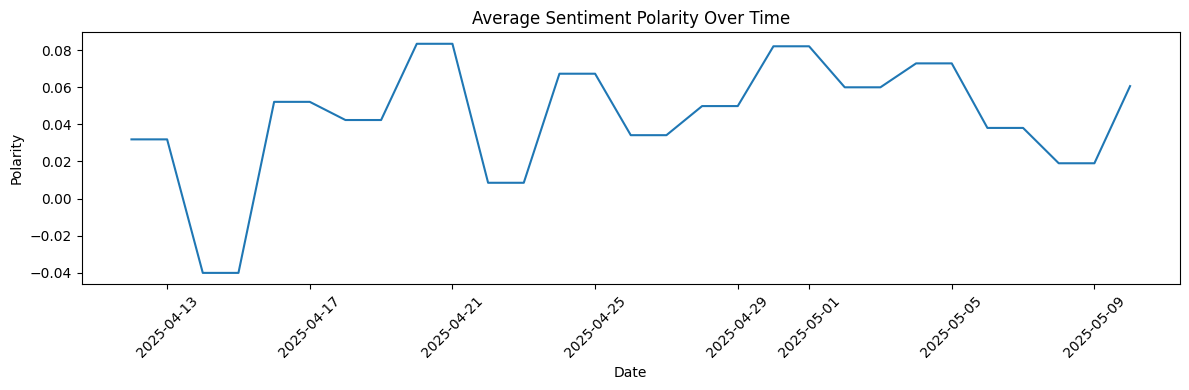

In [38]:
plot_sentiment_trends(aggregated_sentiment)


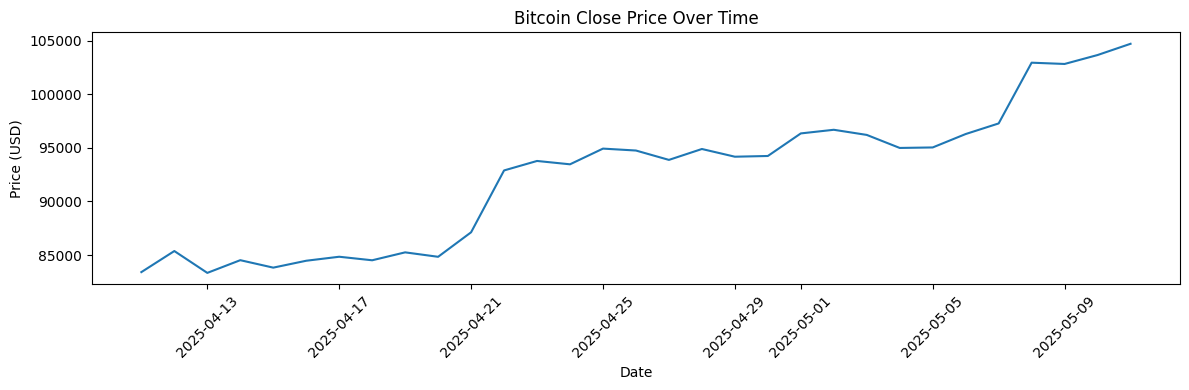

In [39]:
plot_price_trends(price_data)


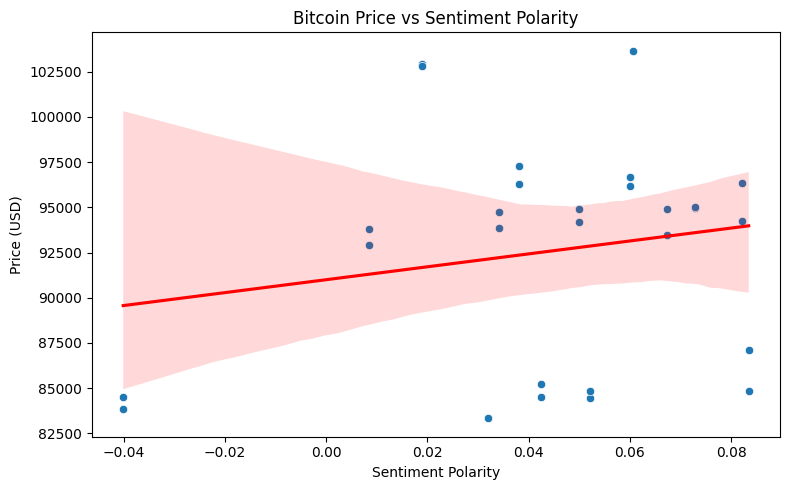

In [40]:
plot_price_vs_sentiment(merged_data)


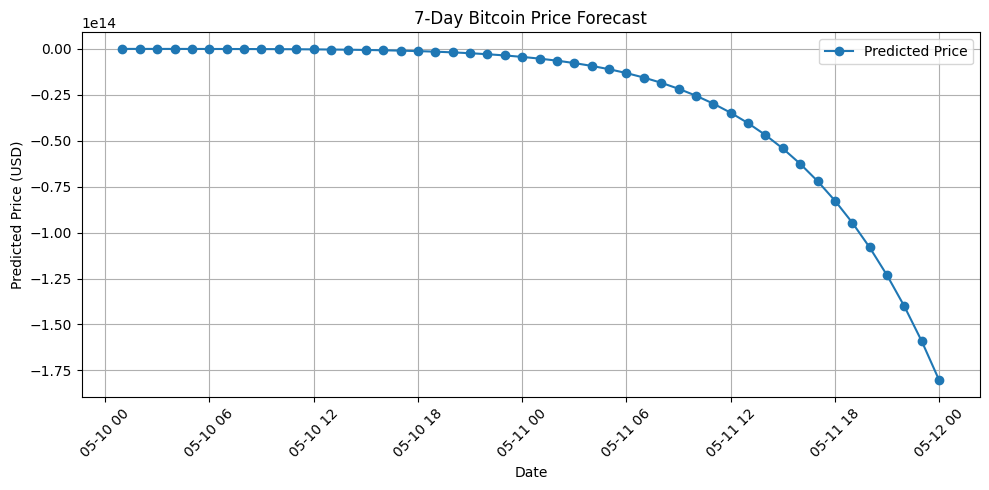

In [41]:
plot_future_forecast(future_forecast)  # if you're returning both results


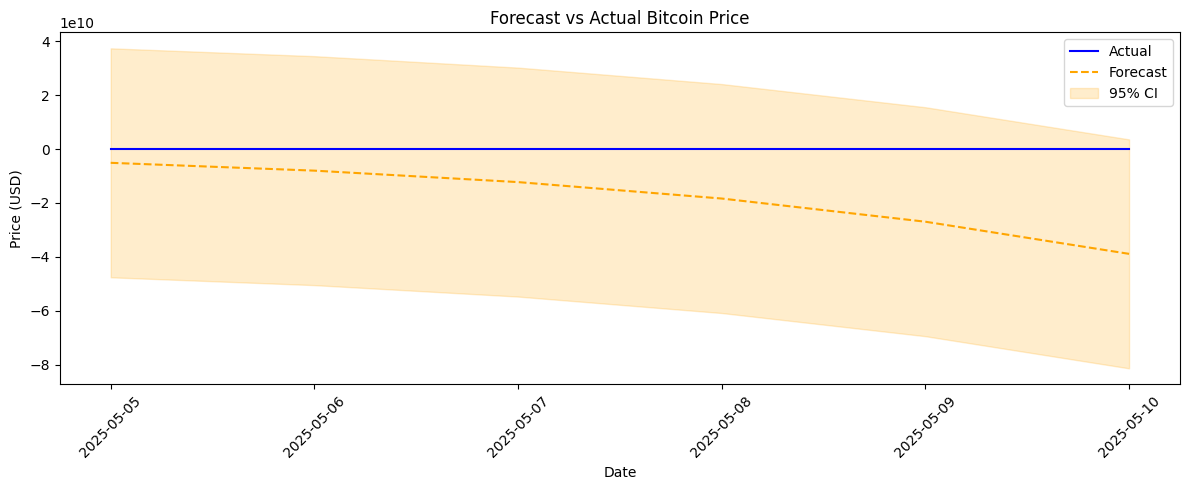

In [42]:
if forecast_results is not None:
    plot_forecast(forecast_results)



In [43]:
# === 6. Historical Comparison (Example) ===
comparison = compare_historical_sentiment(
    base_date=start_date_str,
    comparison_date=end_date_str,
    sentiment_df=aggregated_sentiment,
    price_df=price_data
)
print("\nHistorical Comparison:")
print(comparison)

2025-05-10 22:25:59 - src.utils_analyzer - WARNING - Missing data for comparison between 2025-04-11 and 2025-05-10

Historical Comparison:
None


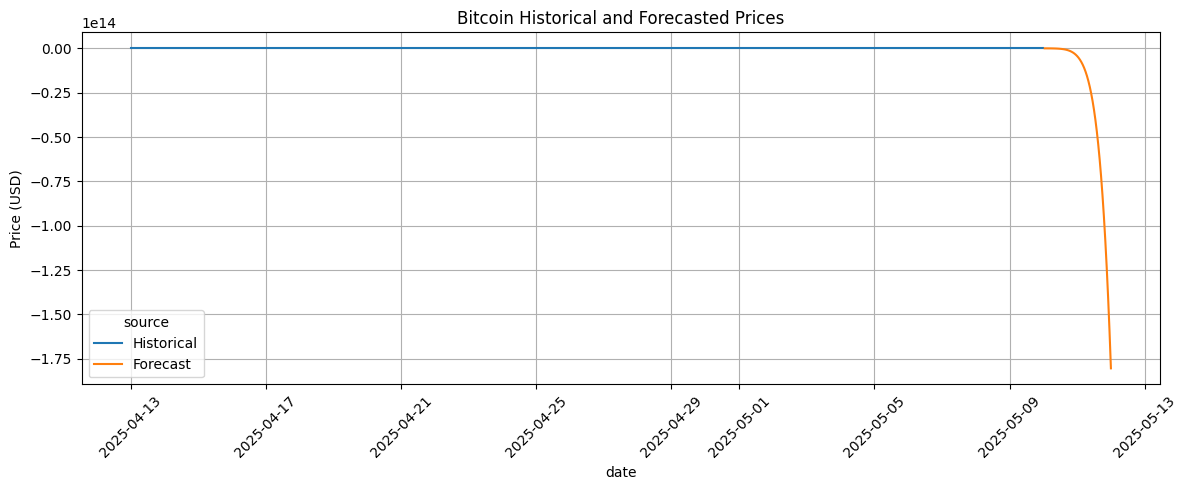

In [44]:
future = future_forecast.copy()
future['price'] = future['predicted_price']
future['source'] = 'Forecast'

historical = merged_data[['date', 'close_price']].copy()
historical['price'] = historical['close_price']
historical['source'] = 'Historical'

trend_df = pd.concat([historical[['date', 'price', 'source']], future[['date', 'price', 'source']]])

# plot it
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.lineplot(data=trend_df, x='date', y='price', hue='source')
plt.title('Bitcoin Historical and Forecasted Prices')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()